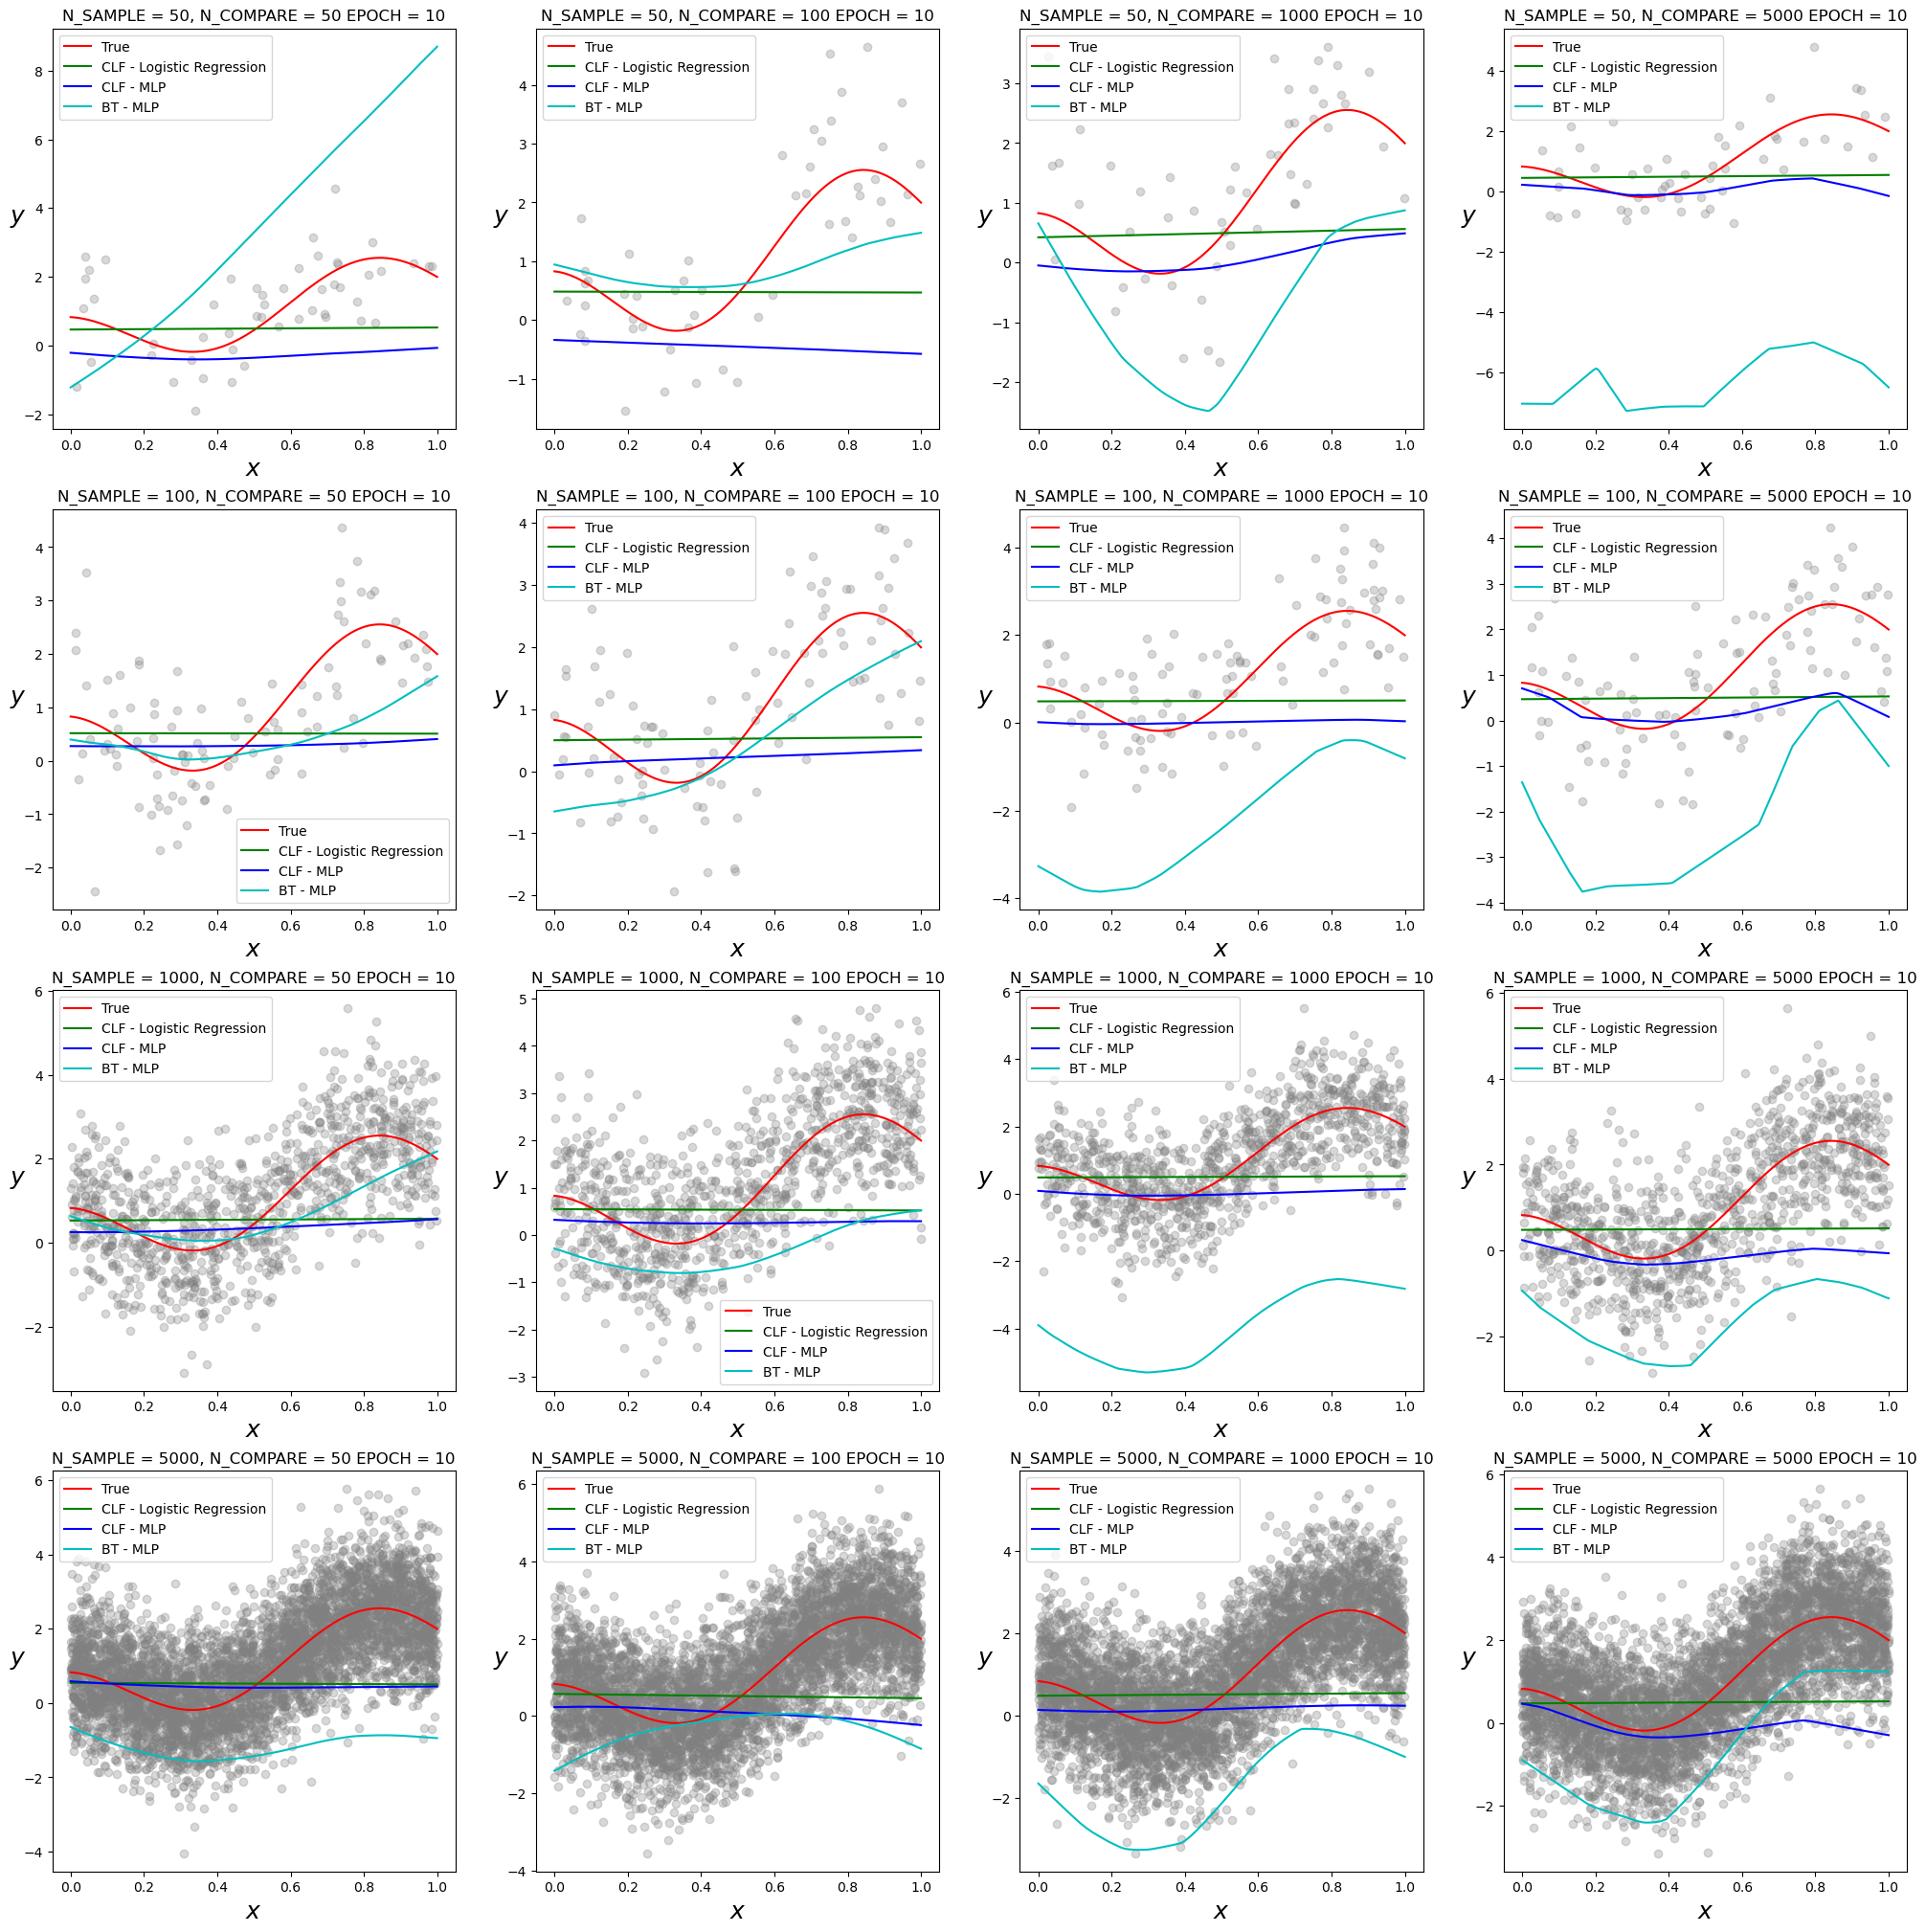

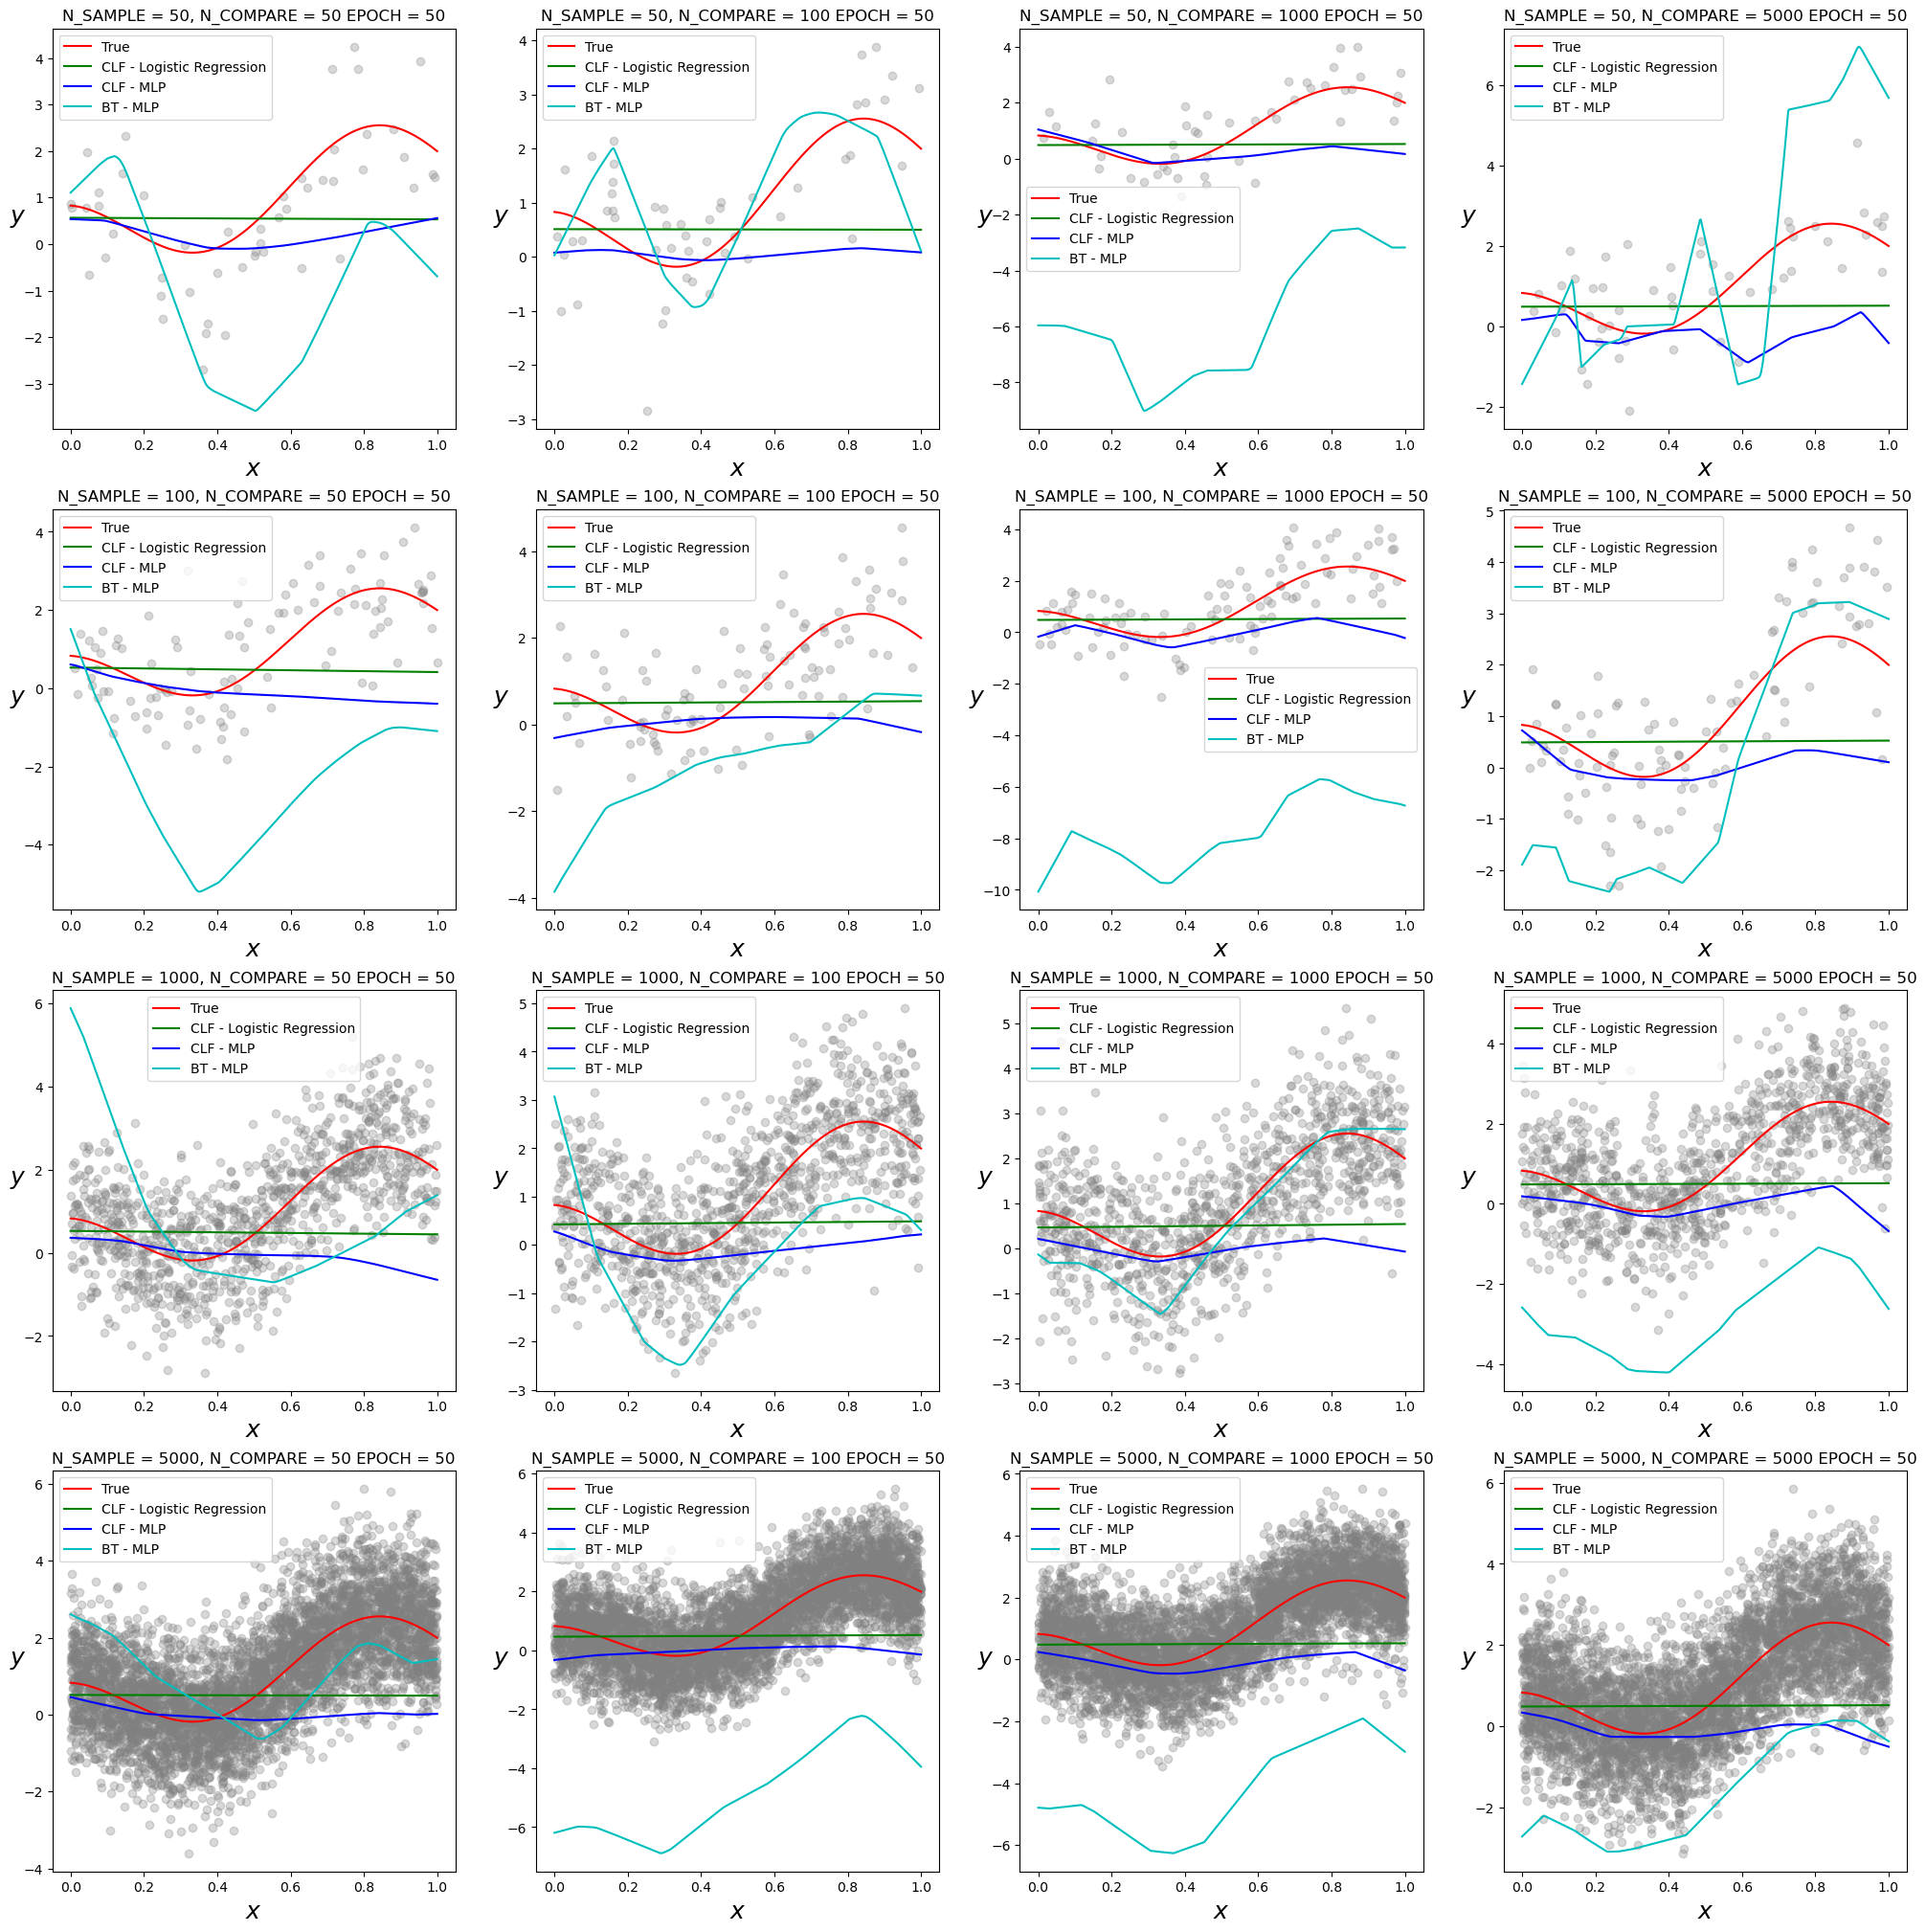

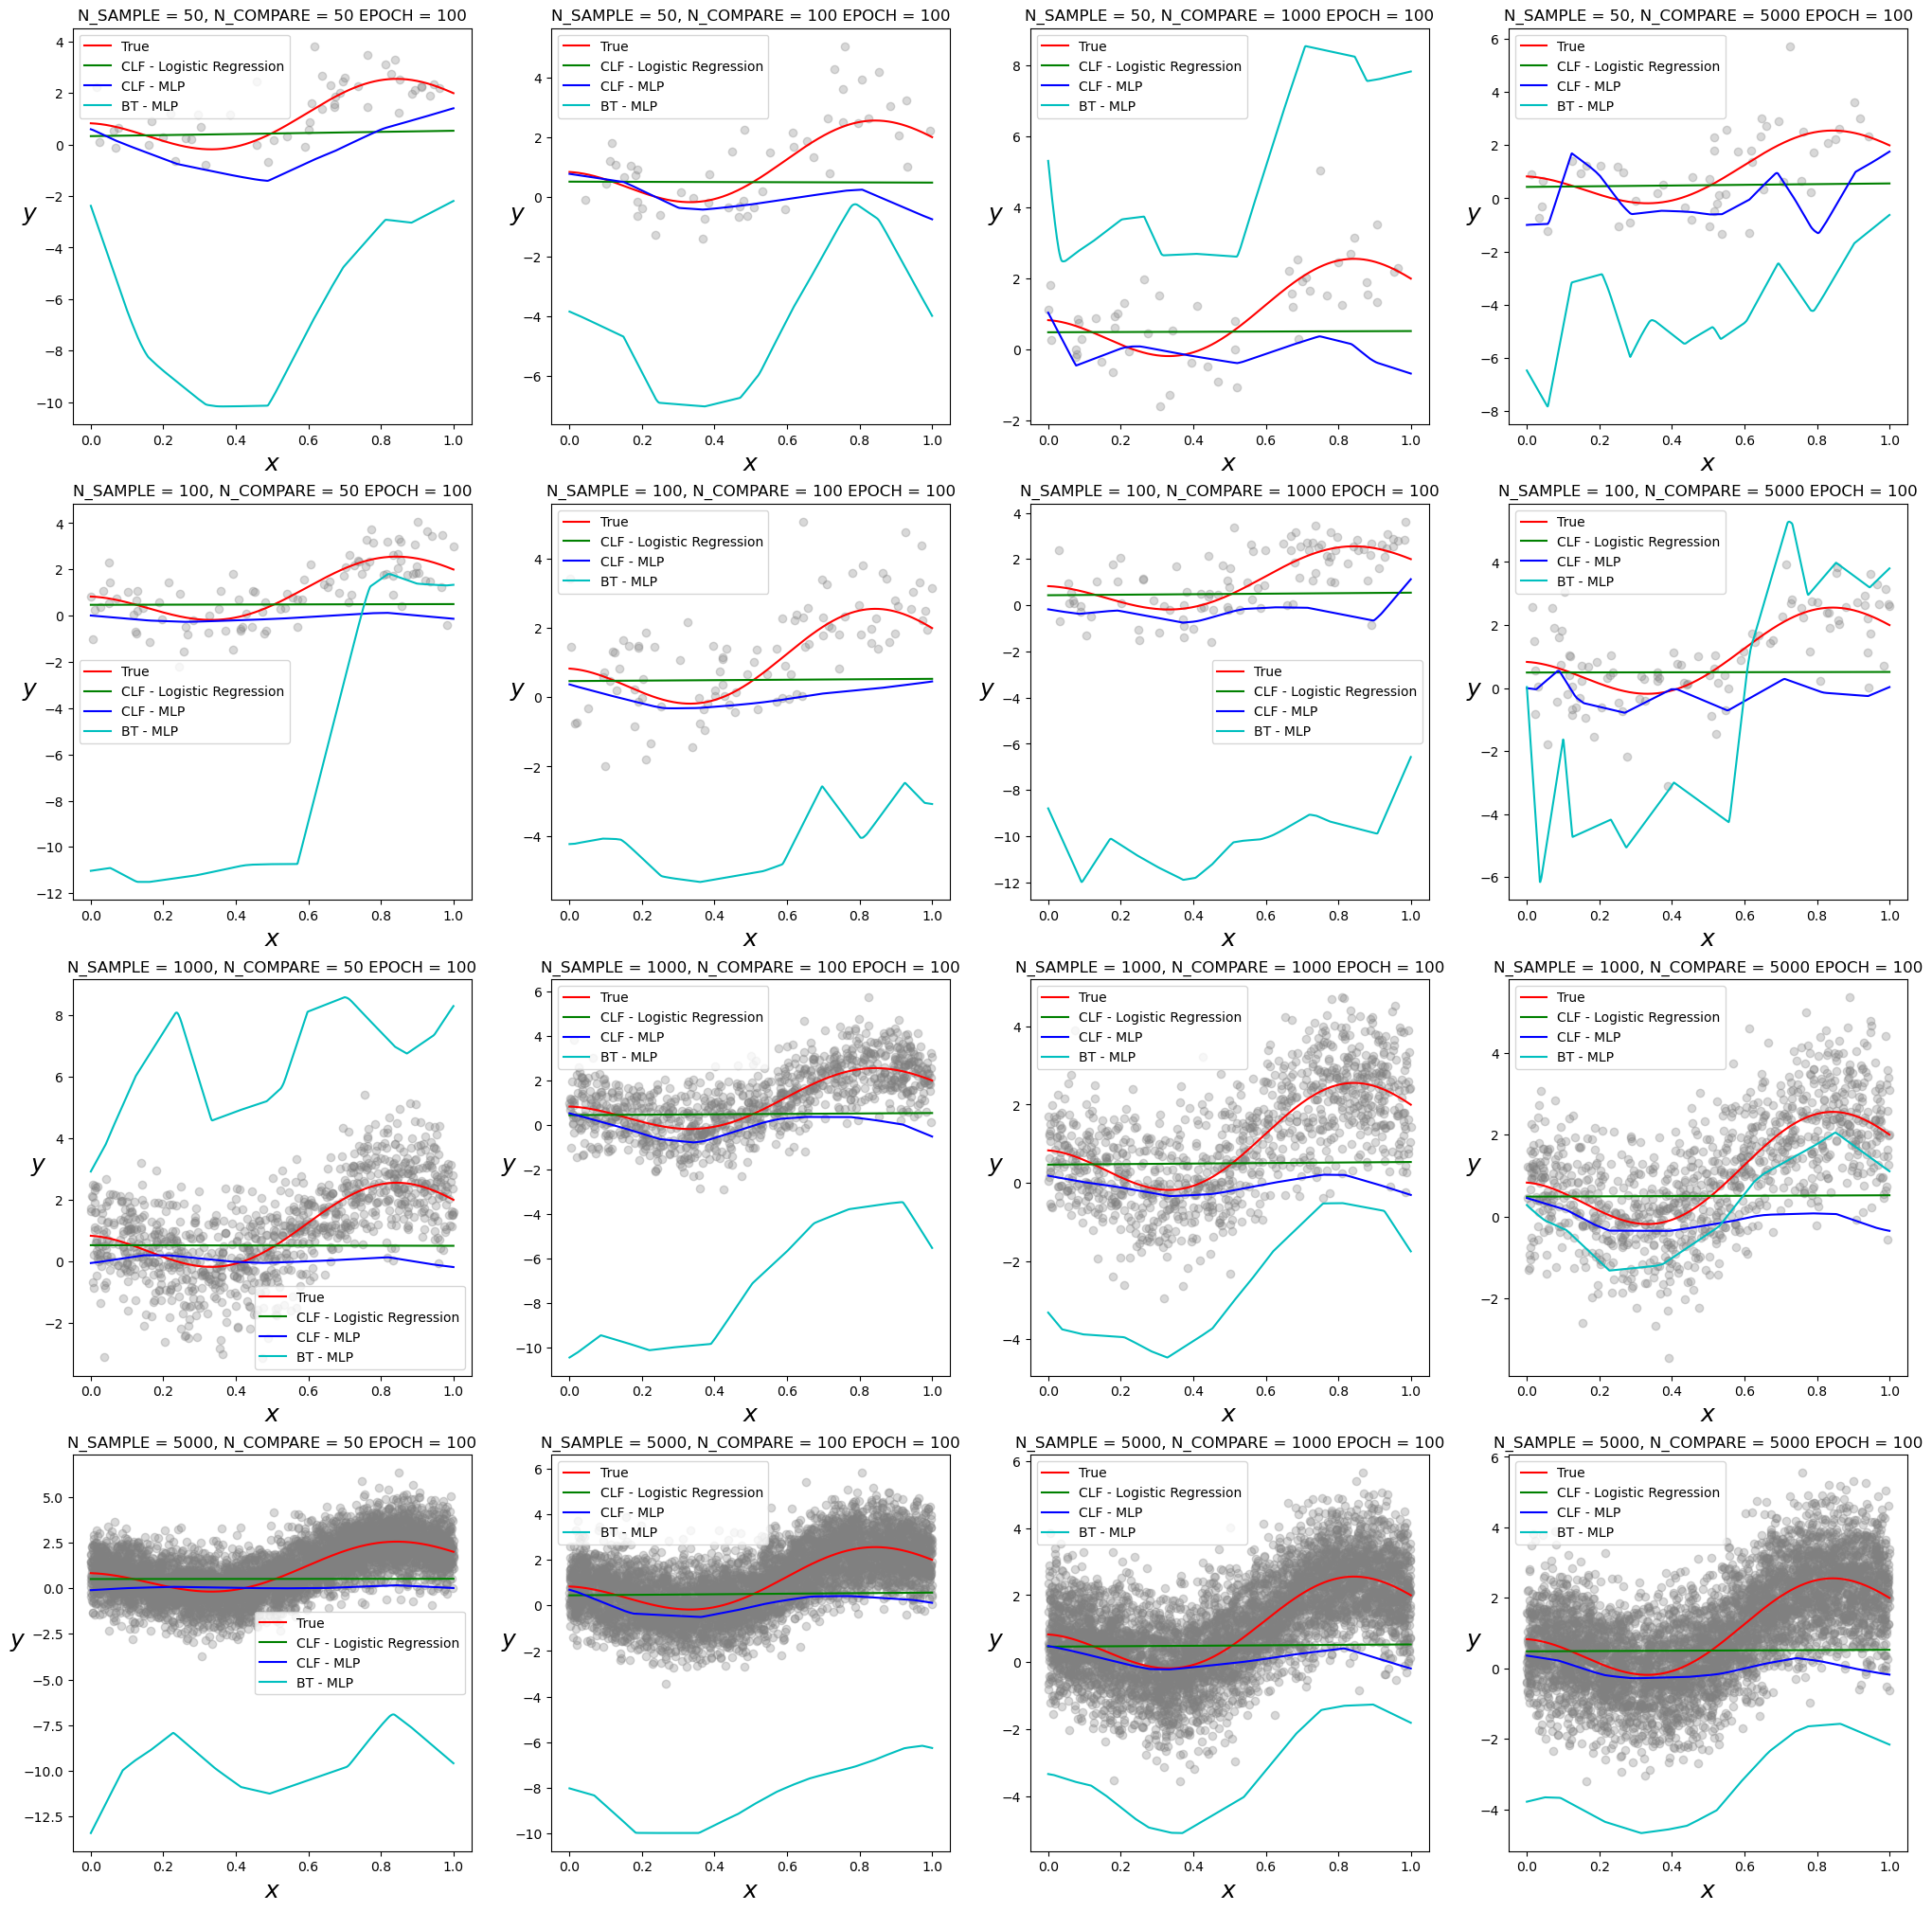

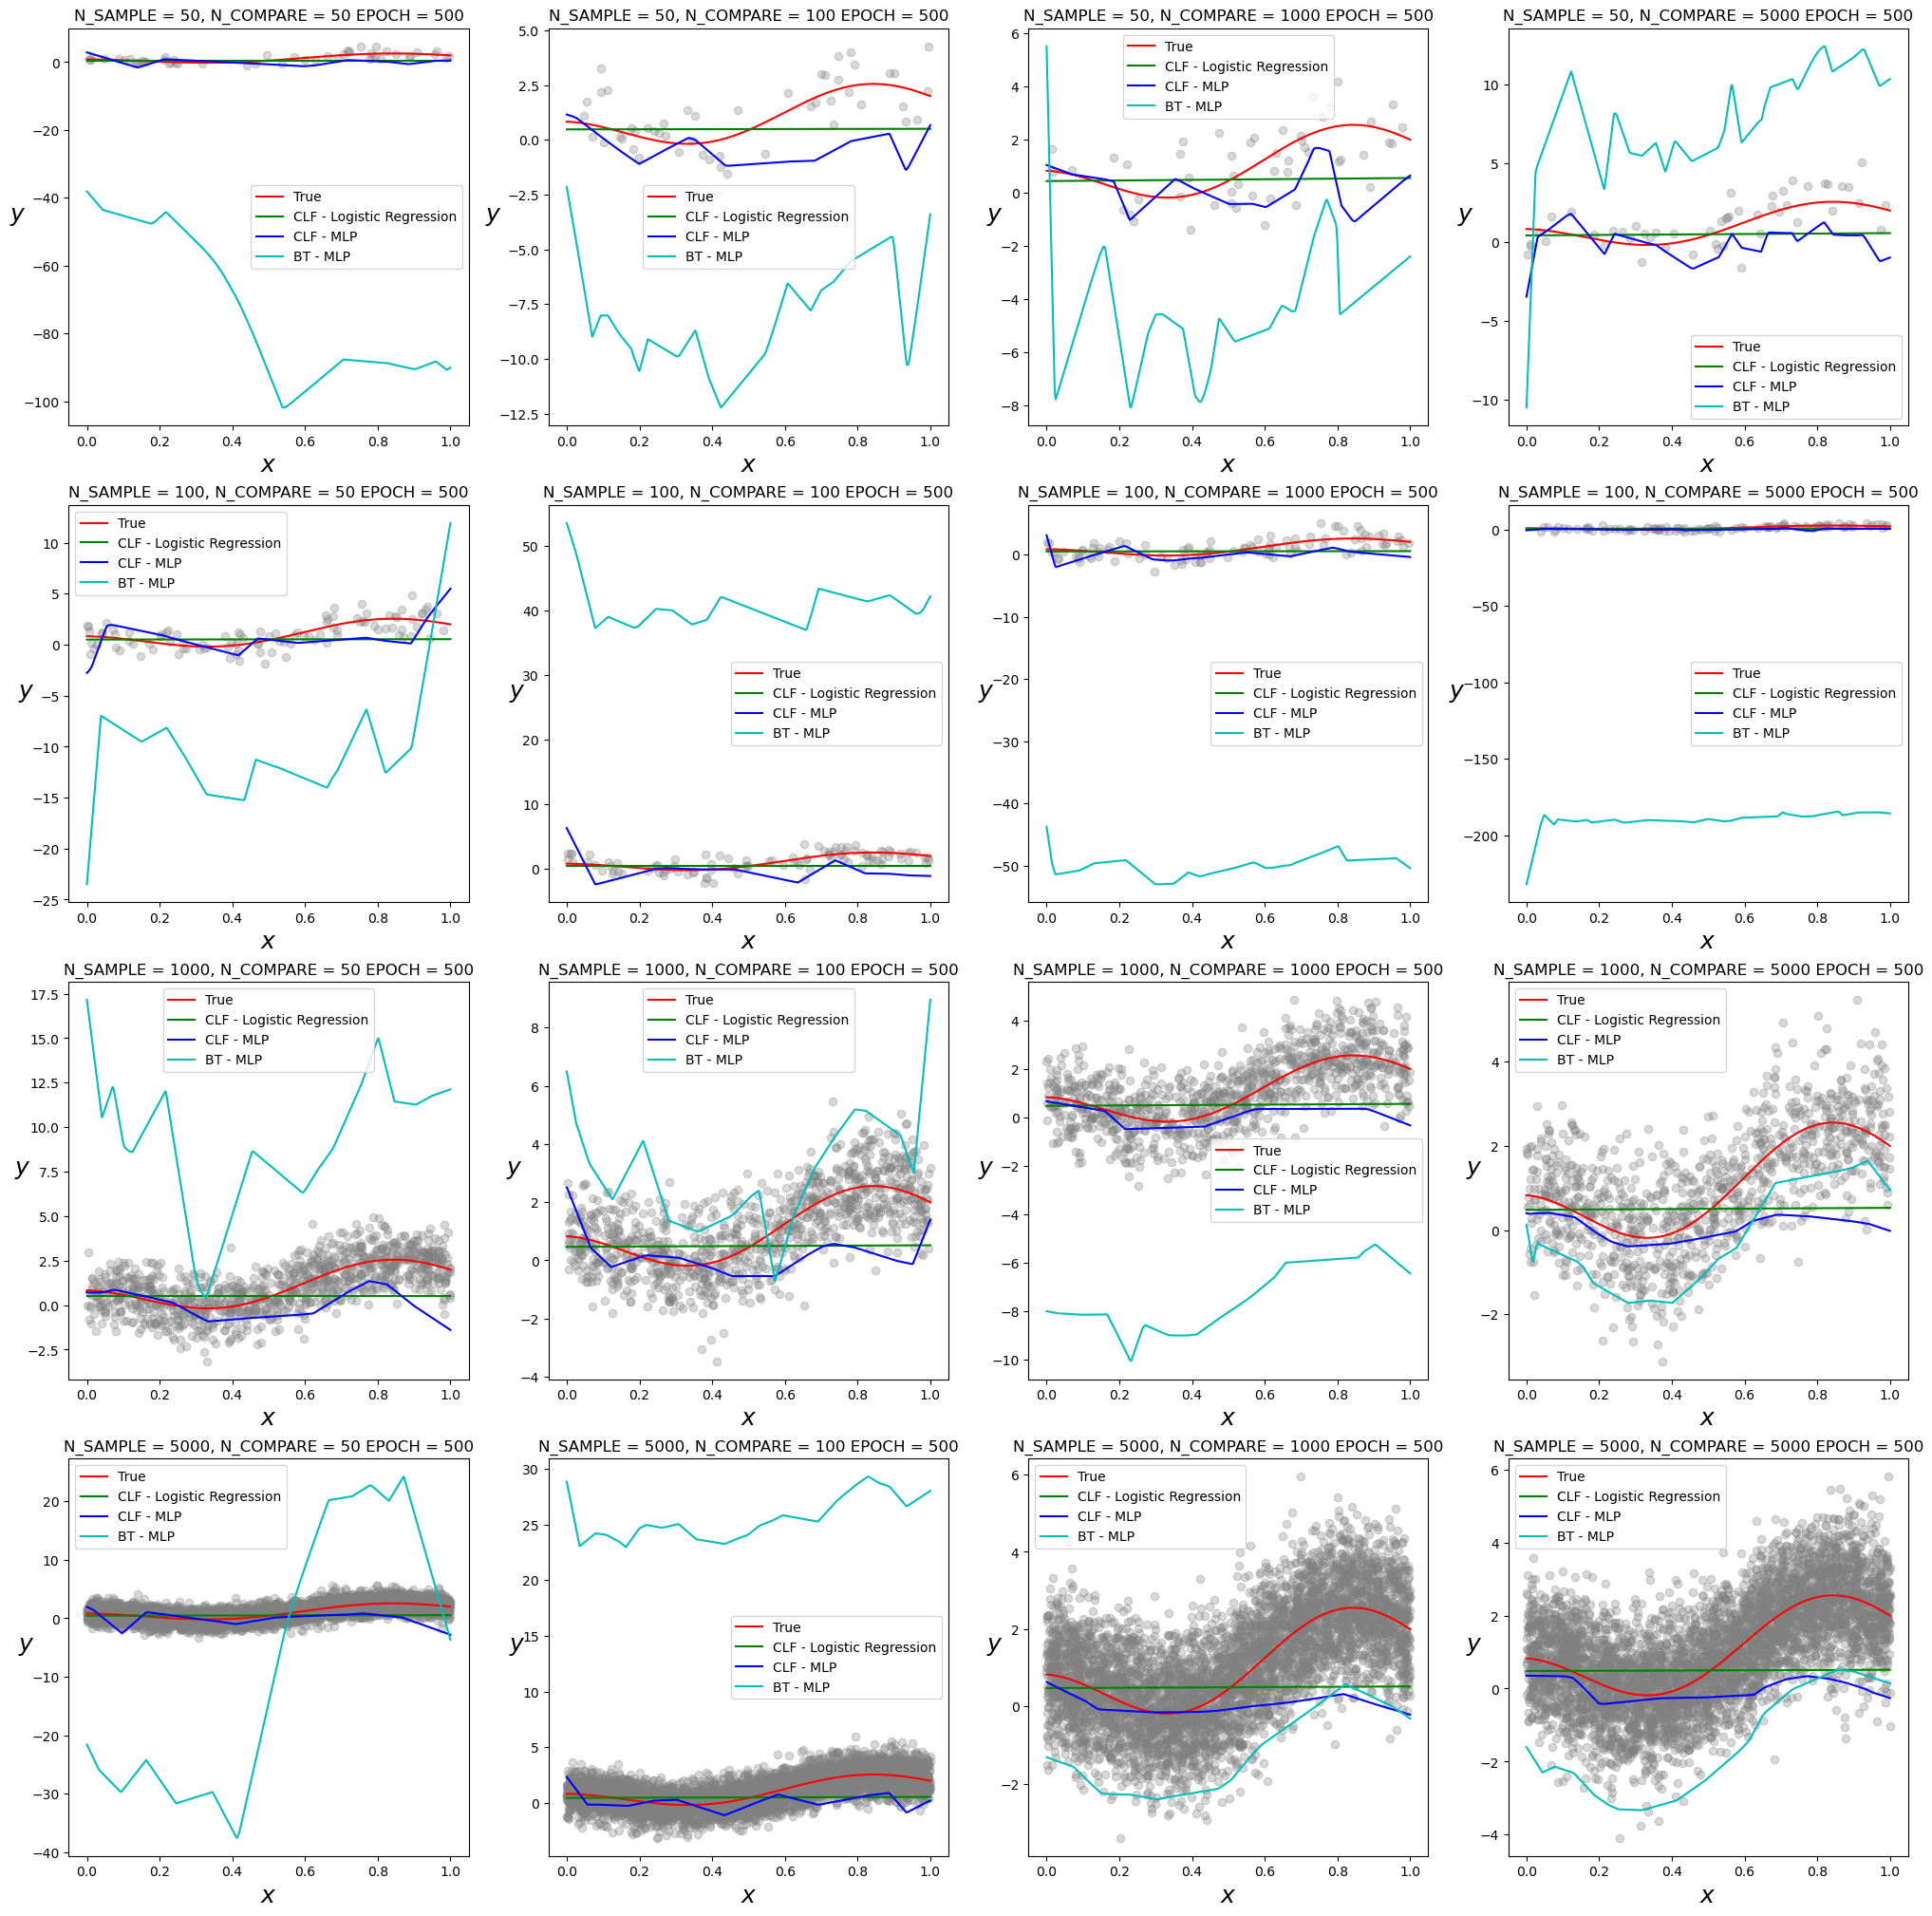

In [2]:
# more complex task:

# create a synthetic regression task:

def func_form(input_x):
    return np.cos(7*input_x+0.5) + 3 * input_x - 0.4 * (input_x+0.5)**3
XLIM =1
LOCAL_THRES = 0.2
import numpy as np
import matplotlib.pyplot as plt
for N_EPOCH in [10, 50, 100, 500]: #
    fig, axes = plt.subplots(4, 4, figsize=(25, 25))
    for j, N_SAMPLE in enumerate([50, 100, 1000, 5000]):
        for k, N_COMPARE in enumerate([50, 100, 1000, 5000]):
            ax = axes[j, k]

            X = np.random.rand(N_SAMPLE, 1) * XLIM
            # y = 2 + 3 * X + np.random.randn(N_SAMPLE, 1)
            y =  func_form(X) + np.random.randn(N_SAMPLE, 1)

            #normalize y to 0-1
            # ymax = y.max()
            # ymin = y.min()

            # y = (y - y.min()) / (y.max() - y.min())
            # y = (y - y.mean())  / y.std()

            # plt.plot(X, y, "b.")
            # plt.xlabel("$x$", fontsize=18)
            # plt.ylabel("$y$", rotation=0, fontsize=18)
            # draw the true line after normalization
            # plt.plot(X, (2 + 3 * X - ymin)/(ymax-ymin), "r")


            # create the pairwise dataset by randomly pick two for comparison:



            pairwise_dataset = []
            pairwise_label = []
            while len(pairwise_dataset) < N_COMPARE:
                # locally sample pairwise data
                idx1 = np.random.randint(0, N_SAMPLE)
                idx2 = np.random.randint(0, N_SAMPLE)
                if np.abs(X[idx1] - X[idx2]) > LOCAL_THRES:
                    continue
                pairwise_dataset.append((X[idx1].item(), X[idx2].item()))
                pairwise_label.append(1 if y[idx1] > y[idx2] else 0)
            # for i in range(N_COMPARE):
            #     # locally sample pairwise data
            #     while
            #     idx1 = np.random.randint(0, N_SAMPLE)
            #     idx2 = np.random.randint(0, N_SAMPLE)
            #     pairwise_dataset.append((X[idx1].item(), X[idx2].item()))
            #     pairwise_label.append(1 if y[idx1] > y[idx2] else 0)

            pairwise_dataset = np.array(pairwise_dataset)
            pairwise_label = np.array(pairwise_label)



            clf_dataset = []
            clf_label = []
            for i, (x1, x2) in enumerate(pairwise_dataset):
                if pairwise_label[i] == 1:
                    clf_dataset.append(x1)
                    clf_label.append(1)
                    clf_dataset.append(x2)
                    clf_label.append(0)
                else:
                    clf_dataset.append(x1)
                    clf_label.append(0)
                    clf_dataset.append(x2)
                    clf_label.append(1)

            clf_dataset = np.array(clf_dataset).reshape(-1, 1)
            clf_label = np.array(clf_label)

            # flip the pairwise data to augment the dataset
            pairwise_dataset = np.vstack([pairwise_dataset, pairwise_dataset[:, ::-1]])
            pairwise_label = np.hstack([pairwise_label, 1 - pairwise_label])




            # logistic regression
            from sklearn.linear_model import LogisticRegression
            from sklearn.model_selection import train_test_split



            X_train, X_test, y_train, y_test = train_test_split(clf_dataset, clf_label, test_size=0.2)
            X_train_siamese, X_test_siamese, y_train_siamese, y_test_siamese = train_test_split(pairwise_dataset, pairwise_label, test_size=0.2)
            log_reg = LogisticRegression()
            log_reg.fit(X_train, y_train)

            # print("Train accuracy: ", log_reg.score(X_train, y_train))
            # print("Test accuracy: ", log_reg.score(X_test, y_test))

            # mlp model
            from networks import MLP, forward_mlp, forward_siamese, train_model
            import torch
            import torch.optim as optim
            import torch.nn as nn

            X_train = torch.tensor(X_train, dtype=torch.float32)
            X_test = torch.tensor(X_test, dtype=torch.float32)
            y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
            y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

            X_train_siamese = torch.tensor(X_train_siamese, dtype=torch.float32).unsqueeze(-1)
            X_test_siamese = torch.tensor(X_test_siamese, dtype=torch.float32).unsqueeze(-1)
            y_train_siamese = torch.tensor(y_train_siamese, dtype=torch.float32).unsqueeze(1)
            y_test_siamese = torch.tensor(y_test_siamese, dtype=torch.float32).unsqueeze(1)

            mlp = MLP(1)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            train_model(mlp, device, 'clf', X_train, y_train, X_test, y_test, N_EPOCH, 0.001)

            # eval the model
            mlp.eval()
            y_logits = forward_mlp(mlp, X_test)
            y_logits = y_logits.detach().numpy()
            y_pred = (y_logits > 0.5).astype(int)
            # print("Test accuracy CLF: ", np.mean(y_pred == y_test.numpy()))

            bt = MLP(1)
            train_model(bt, device, 'siamese', X_train_siamese, y_train_siamese, X_test_siamese, y_test_siamese, N_EPOCH, 0.001)
            bt.eval()
            y_logits_bt = forward_siamese(bt, X_test_siamese[:, 0], X_test_siamese[:, 1])
            y_logits_bt = y_logits_bt.detach().numpy()
            y_pred_bt = (y_logits_bt > 0.5).astype(int)
            # print("Test accuracy BT: ", np.mean(y_pred_bt == y_test_siamese.numpy()))



            # predict the probability of any given data
            X_new = np.linspace(0, XLIM, 1000).reshape(-1, 1)
            y_proba = log_reg.predict_proba(X_new)
            y_mlp_logits = mlp(torch.tensor(X_new, dtype=torch.float32)).detach().numpy()
            y_bt_logits = bt(torch.tensor(X_new, dtype=torch.float32)).detach().numpy()

            # plt.plot(X_train, y_train, "b.")
            # plt.plot(X_test, y_test, "g.")
            ax.scatter(X, y, c='gray',alpha=0.3)
            ax.set_xlabel("$x$", fontsize=18)
            ax.set_ylabel("$y$", rotation=0, fontsize=18)
            # draw the true line after normalization

            line_dots = np.linspace(0, XLIM, 1000).reshape(-1, 1)
            ax.plot(line_dots, func_form(line_dots), "r", label="True")
            # draw the true functional curve

            ax.plot(X_new, y_proba[:, 1], "g-", label="CLF - Logistic Regression")
            ax.plot(X_new, y_mlp_logits, "b-", label="CLF - MLP")
            ax.plot(X_new, y_bt_logits, "c-", label="BT - MLP")
            ax.set_title(f"N_SAMPLE = {N_SAMPLE}, N_COMPARE = {N_COMPARE} EPOCH = {N_EPOCH} Local={LOCAL_THRES}")
            ax.legend()
            # plt.show()
    plt.show()